In [1]:
main_folder = r"D:\Data Science\Coconut Tree Disease Data"
train_folder = r"D:\Data Science\Coconut Tree Disease Data\train"
test_folder = r"D:\Data Science\Coconut Tree Disease Data\test"

In [2]:
import os
os.mkdir(main_folder)
os.mkdir(train_folder)
os.mkdir(test_folder)

In [7]:
!fusermount -u /content/drive
!rm -rf /content/drive




fusermount: failed to unmount /content/drive: Invalid argument


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import os
import shutil

# Suppose you have these directories on Google Drive:
drive_source_train = "/content/drive/MyDrive/Coconut Tree Disease Data - Copy/train"
drive_source_test = "/content/drive/MyDrive/Coconut Tree Disease Data - Copy/test"
drive_source_validation = "/content/drive/MyDrive/Coconut Tree Disease Data - Copy/validation"

# Create a temporary directory to combine all images
combined_source = "/content/drive/MyDrive/Coconut Tree Disease Data - Copy/combined_dataset"
os.makedirs(combined_source, exist_ok=True)

# A helper function to merge images from one folder into the combined folder, maintaining class structure.
def merge_images(source_dir, combined_dir):
    for class_name in os.listdir(source_dir):
        class_source_path = os.path.join(source_dir, class_name)
        if os.path.isdir(class_source_path):
            class_destination_path = os.path.join(combined_dir, class_name)
            os.makedirs(class_destination_path, exist_ok=True)
            for image in os.listdir(class_source_path):
                # Generate a unique filename if needed to avoid overwriting
                src_file = os.path.join(class_source_path, image)
                dst_file = os.path.join(class_destination_path, image)
                shutil.copy(src_file, dst_file)

# Merge all folders into the combined dataset
merge_images(drive_source_train, combined_source)
merge_images(drive_source_test, combined_source)
merge_images(drive_source_validation, combined_source)


In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
import time

#tf.config.set_visible_devices(pd[0], 'GPU')

In [11]:
pd = print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


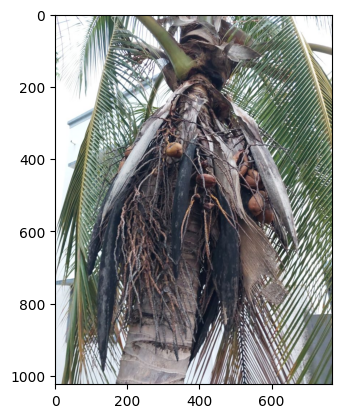

Input shape: (1024, 768, 3)


In [13]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Open the image using PIL (Python Imaging Library)
with Image.open("/content/drive/MyDrive/Coconut Tree Disease Data - Copy/combined_dataset/Bud Root Dropping/BudRootDropping001.jpg") as img:
    # Get the width and height of the image
    img_array = np.array(img)
    # Plot the image
    plt.imshow(img_array)
    plt.show()

    width, height = img.size
    # Get the number of channels (1 for grayscale, 3 for RGB)
    channels = len(img.getbands())

# Determine the input shape
input_shape = (height, width, channels)

print("Input shape:", input_shape)


In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Create the augmented directory if it doesn't exist
augmented_dir = "/content/drive/MyDrive/Coconut Tree Disease Data - Copy/augmented"
os.makedirs(augmented_dir, exist_ok=True)

# Define the ImageDataGenerator with augmentation options
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_dir = "/content/drive/MyDrive/Coconut Tree Disease Data - Copy/train"  # Adjust this to your directory

# Generate augmented images
i = 0
for batch in train_datagen.flow_from_directory(
                                                    train_dir,
                                                    target_size=(100, 100),
                                                    class_mode='categorical',
                                                    batch_size=50,
                                                    color_mode="rgb",
                                                    save_to_dir=augmented_dir,  # Save to Drive
                                                    save_format="jpg"
                                                  ):
    i += 1
    if i > 41:
        break


Found 4637 images belonging to 5 classes.


In [17]:
### augmentation
#### Define augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1.0/255,  # Rescale pixel values to [0, 1]
    rotation_range=20,  # Rotate images randomly within the range [-20, 20] degrees
    width_shift_range=0.2,  # Shift images horizontally by up to 20% of the image width
    height_shift_range=0.2,  # Shift images vertically by up to 20% of the image height
    shear_range=0.2,  # Apply shear transformation with a shear intensity of up to 20%
    zoom_range=0.2,  # Zoom in or out by up to 20%
    horizontal_flip=True,  # Flip images horizontally (left to right) randomly
    fill_mode='nearest'  # Strategy for filling in newly created pixels
)

In [18]:
train_dir = "/content/drive/MyDrive/Coconut Tree Disease Data - Copy/train"
test_dir = "/content/drive/MyDrive/Coconut Tree Disease Data - Copy/test"
validation_dir = "/content/drive/MyDrive/Coconut Tree Disease Data - Copy/validation"

train_generator = train_datagen.flow_from_directory(
                                    train_dir,
                                    target_size=(256, 256),
                                    class_mode='categorical',
                                    batch_size=50
                                )

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
                                                    test_dir,
                                                    target_size=(256, 256),
                                                    class_mode='categorical',
                                                    batch_size=50,
                                                    shuffle=False
                                                  )

validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(
                                                    validation_dir,
                                                    target_size=(256, 256),
                                                    class_mode='categorical',
                                                    batch_size=50,
                                                    shuffle=False
                                                  )


Found 4637 images belonging to 5 classes.
Found 583 images belonging to 5 classes.
Found 578 images belonging to 5 classes.


In [19]:
train_generator.image_shape

(256, 256, 3)

In [20]:
model = tf.keras.models.Sequential([
      Conv2D(16, (5,5), activation='relu', input_shape = train_generator.image_shape),
      MaxPooling2D(2, 2),
      Conv2D(32, (5,5), activation='relu'),
      MaxPooling2D(5, 5),
      Conv2D(64, (5,5), activation='relu'),
      MaxPooling2D(2, 2),
      Flatten(),
      Dense(512, activation='relu'),
      Dropout(0.2),
      Dense(1024, activation='relu'),
      Dropout(0.2),
      Dense(5, activation='softmax')
])
model.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics = ['acc'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 252, 252, 16)   │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 126, 126, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 122, 122, 32)   │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,873,061 (14.77 MB)

 Trainable params: 3,873,061 (14.77 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_acc', patience = 2, min_delta=0.01)

In [23]:
st = time.time()
model.fit(train_generator,
          epochs=25,
          verbose=1,
          validation_data=validation_generator,
          callbacks=[es])
end = time.time()
print(end - st)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 575s 6s/step - acc: 0.4111 - loss: 1.3190 - val_acc: 0.7145 - val_loss: 0.6639
Epoch 2/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 571s 6s/step - acc: 0.7041 - loss: 0.7065 - val_acc: 0.7664 - val_loss: 0.5874
Epoch 3/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 569s 6s/step - acc: 0.7818 - loss: 0.5522 - val_acc: 0.8841 - val_loss: 0.3619
Epoch 4/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 568s 6s/step - acc: 0.8358 - loss: 0.4490 - val_acc: 0.9100 - val_loss: 0.2518
Epoch 5/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 569s 6s/step - acc: 0.8857 - loss: 0.3138 - val_acc: 0.9187 - val_loss: 0.2177
Epoch 6/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 569s 6s/step - acc: 0.9107 - loss: 0.2371 - val_acc: 0.8893 - val_loss: 0.2649
3423.6079881191254


In [24]:
model.evaluate(test_generator)

12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - acc: 0.8967 - loss: 0.2776


[0.23881319165229797, 0.9108061790466309]

In [25]:
y_pred = model.predict(test_generator)
y_true = test_generator.classes

12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step


In [26]:
y_pred.shape , y_true.shape

((583, 5), (583,))

In [27]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Convert probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Print classification report
print(classification_report(y_true, y_pred_labels))



              precision    recall  f1-score   support

           0       0.76      1.00      0.87        52
           1       0.89      0.89      0.89        47
           2       1.00      0.81      0.90       214
           3       0.88      0.96      0.92       168
           4       0.91      1.00      0.95       102

    accuracy                           0.91       583
   macro avg       0.89      0.93      0.91       583
weighted avg       0.92      0.91      0.91       583



In [28]:
print(confusion_matrix(y_true, y_pred_labels))

[[ 52   0   0   0   0]
 [  2  42   0   3   0]
 [  7   5 174  18  10]
 [  7   0   0 161   0]
 [  0   0   0   0 102]]


In [29]:
# Save the custom CNN model
model.save('custom_coconut_disease_model.h5')

In [30]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model

In [31]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [32]:
# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

In [33]:
# Add your custom classification layers on top of the pre-trained layers
l = base_model.output
l = Flatten()(l)
l = Dense(512, activation='relu')(l)
l = Dropout(0.2)(l)
l = Dense(1024, activation='relu')(l)
l = Dropout(0.2)(l)
predictions = Dense(5, activation='softmax')(l)

In [34]:
# Combine the base model with your custom layers
model1 = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model1.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 127, 127,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 127, 127,  │         96 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 127, 127,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 125, 125,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │         96 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 125, 125,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 125, 125,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │        192 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 125, 125,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 62, 62,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 62, 62,    │      5,120 │ max_pooling2d_3[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 62, 62,    │        240 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 62, 62,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 60, 60,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 60,    │        576 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 60, 60,    │          0 │ batch_normalizat

 Total params: 60,082,469 (229.20 MB)

 Trainable params: 38,279,685 (146.03 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [35]:
es1 = EarlyStopping(monitor='val_accuracy', patience = 2, min_delta=0.01)

In [37]:
# Train the model
start_time = time.time()
history = model1.fit(
                    train_generator,
                    epochs=25,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks=[es1]
                    )
end_time = time.time()
print("Training time:", end_time - start_time)


Epoch 1/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 1140s 12s/step - accuracy: 0.6073 - loss: 11.9189 - val_accuracy: 0.9550 - val_loss: 0.1396
Epoch 2/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 1094s 12s/step - accuracy: 0.9126 - loss: 0.2701 - val_accuracy: 0.9637 - val_loss: 0.1301
Epoch 3/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 1096s 12s/step - accuracy: 0.9193 - loss: 0.2446 - val_accuracy: 0.9758 - val_loss: 0.1068
Epoch 4/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 1171s 13s/step - accuracy: 0.9301 - loss: 0.2130 - val_accuracy: 0.9862 - val_loss: 0.0989
Epoch 5/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 1091s 12s/step - accuracy: 0.9411 - loss: 0.1735 - val_accuracy: 0.9792 - val_loss: 0.0788
Epoch 6/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 1100s 12s/step - accuracy: 0.9462 - loss: 0.1609 - val_accuracy: 0.9844 - val_loss: 0.0670
Training time: 6696.108899593353


In [38]:
# Evaluate the model
y_pred = model1.predict(test_generator)
y_true = test_generator.classes

# Convert probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Print classification report and confusion matrix
print(classification_report(y_true, y_pred_labels))

12/12 ━━━━━━━━━━━━━━━━━━━━ 126s 10s/step
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        52
           1       1.00      0.91      0.96        47
           2       0.95      0.98      0.97       214
           3       0.96      0.95      0.95       168
           4       1.00      1.00      1.00       102

    accuracy                           0.97       583
   macro avg       0.98      0.97      0.97       583
weighted avg       0.97      0.97      0.97       583



In [39]:
print(confusion_matrix(y_true, y_pred_labels))

[[ 52   0   0   0   0]
 [  1  43   2   1   0]
 [  0   0 209   5   0]
 [  1   0   8 159   0]
 [  0   0   0   0 102]]


In [40]:
# Save the InceptionV3 model
model1.save('inceptionV3_coconut_disease_model.h5')

In [42]:
# Save custom model in native Keras format
model.save('/content/drive/MyDrive/custom_coconut_disease_model.keras')

# Save InceptionV3 model in native Keras format
model1.save('/content/drive/MyDrive/inceptionV3_coconut_disease_model.keras')
